<h2 style="color: #0074D9;">Table of Contents</h2>
<ol>
    <li><a href="#Data" style="font-size: larger; color: #0074D9; font-weight: bold;">Data Loading</a></li>
    <li><a href="#IntMatr" style="font-size: larger; color: #0074D9; font-weight: bold;">Interaction Matrix</a></li>
    <li><a href="#Split" style="font-size: larger; color: #0074D9; font-weight: bold;">Train/Test split</a></li>
    <li><a href="#Baseline" style="font-size: larger; color: #0074D9; font-weight: bold;">Baseline POP-Recommender</a></li>
    <li><a href="#Evaluation" style="font-size: larger; color: #0074D9; font-weight: bold;">Evaluation</a></li>
</ol>

In [44]:
#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')

#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix , save_npz, load_npz
from sklearn.model_selection import train_test_split


<h1 style="color:rgb(0,120,170)">Dataset: MIND-small</h1>

------------------------------------------------------

<a id="Data"></a>
#entity_embedding.vec ->	The embeddings of **entities** in news extracted from knowledge graph (prob Nodes) <br>
#relation_embedding.vec	->  The embeddings of **relations** between entities extracted from knowledge graph (ig Edges?)<br>
#both [ID (retrievable from news dataset: columns) - EMB VALUES]

In [ ]:
news = 'MINDsmall_train/news.tsv'
behavior = 'MINDsmall_train/behaviors.tsv'
#news_test = 'MINDlarge_test/news.tsv'
#news_valid = 'MINDlarge_val/news.tsv'

def load_news_df(path):
    if 'news' in path:
        columns = ['News ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract",
                "URL",
                "Title Entities",
                "Abstract Entities "]
    
    elif 'behavior' in path:
        columns = ['Impression ID',
                "User ID",
                "Time",
                "History",
                "Impressions"]
    
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    return df

#load data
news, behavior = load_news_df(news), load_news_df(behavior)
interaction_matrix = pd.read_parquet('interaction_matrix.parquet')

print(news.shape) # --->(51282, 8)
print(behavior.shape)#--->(156965, 5)



"@TO-DO (possibly): use only news with category = 'news' & subcategory = 'newspolitics'"
#news = news[(news['Category'] == 'news') & (news['SubCategory'] == 'newspolitics')] #--->(2826, 8)



<h1 style="color:rgb(0,120,170)">Interaction Matrix</h1>

------------------------------------------------------

<a id="IntMatr"></a>


In [3]:
#initialize interaction matrix shape (users, news)
interaction_matrix_small = pd.DataFrame(0, index=behavior['User ID'].unique(), columns=news['News ID'].unique())
print(interaction_matrix_small.shape) #--->(50000, 51282)

(50000, 51282)


#NEXT: populate it using both history and impressions<br><br>
**Q: binary coding (1,0) vs ternary coding (1,0,-1)** ? <br>
PRO (TERNARY): deeplearning algo leverage negative feedback efficiently<br>
CONTRO: More complex, possible noise (non click != non interest is not given)

In [4]:
behavior["History"] = behavior["History"].apply(lambda x: x.split(" ") if isinstance(x, str) else [])#make it iterable
behavior["Impressions"] = behavior["Impressions"].apply(lambda x: x.split(" ") if isinstance(x, str) else [])

updates = {}

for index, row in behavior.iterrows():
    user_id = row['User ID']
    
    #binary encoding to populate matrix
    for news_id in row['History']:                          #w/ history
        if news_id in interaction_matrix_small.columns:
            updates[(user_id, news_id)] = 1
            
    
    for impression in row['Impressions']:                   #w/ impression
        news_id, clicked = impression.split('-')
        if clicked == '1' and news_id in interaction_matrix_small.columns:
            updates[(user_id, news_id)] = 1

for (user_id, news_id), value in updates.items():
    interaction_matrix_small.at[user_id, news_id] = value


In [ ]:
#visualize e.g. first 10 
interaction_matrix_small = interaction_matrix_small.astype('int8')#it's just 1 and 0
interaction_matrix_small.iloc[:10, :10]


In [6]:
#filter out user and news that have/have been interacted less than 5 times
# columns = news ID
cols_to_keep = interaction_matrix_small.columns[interaction_matrix_small.sum(axis=0) >= 5]
interaction_matrix_filtered = interaction_matrix_small[cols_to_keep]

# rows(index) = user ID
rows_to_keep = interaction_matrix_filtered.index[interaction_matrix_filtered.sum(axis=1) >= 5]
interaction_matrix_filtered = interaction_matrix_filtered.loc[rows_to_keep]

#interaction_matrix_filtered.shape---->(46600, 15520)

In [9]:
#ensure every user has interacted with at least 5 news, and every news has been clicked by at least 5 users
def filter_interaction_matrix(matrix, min_interactions=5):
    while True:
        user_interactions = matrix.sum(axis=1)
        news_interactions = matrix.sum(axis=0)
        users_to_keep = user_interactions[user_interactions >= min_interactions].index
        news_to_keep = news_interactions[news_interactions >= min_interactions].index
        new_matrix = matrix.loc[users_to_keep, news_to_keep]
        if new_matrix.shape == matrix.shape:
            break
        matrix = new_matrix

    return new_matrix

interaction_matrix_filtered = filter_interaction_matrix(interaction_matrix_small)


In [45]:
#sanity check
print("min int per user:", interaction_matrix_filtered.sum(axis=1).min())
print("min int per news:", interaction_matrix_filtered.sum(axis=0).min())
print("max int per user:", interaction_matrix_filtered.sum(axis=1).max())
print("max int per news:", interaction_matrix_filtered.sum(axis=0).max())
print(interaction_matrix_filtered.shape)

#all good let's save it
interaction_matrix_csr = csr_matrix(interaction_matrix_filtered.values)
print(interaction_matrix_csr.shape)#--->(46594, 15471)
save_npz('interaction_matrix.npz', interaction_matrix_csr)

min int per user: 5
min int per news: 5
max int per user: 525
max int per news: 4671
(46594, 15471)
(46594, 15471)


<h1 style="color:rgb(0,120,170)">Train/Test split</h1>

------------------------------------------------------

<a id="Split"></a>
stratified split ensure both train and test have instance for the same users: imp bc avoid cold start problem

In [46]:
interaction_matrix_csr = load_npz('interaction_matrix.npz')

In [61]:
users, items = interaction_matrix_csr.nonzero()
interactions = list(zip(users, items))
interactions_by_user = {}                   # {user: [item1, item2, ...]}
for user, item in interactions:
    if user not in interactions_by_user:
        interactions_by_user[user] = []
    interactions_by_user[user].append(item)


def stratified_train_test_split(interactions_by_user, test_size=0.2):
    train_interactions = []
    test_interactions = []

    for user, items in interactions_by_user.items():
        np.random.shuffle(items)
        n_test = max(int(len(items) * test_size), 1)  # at least 1 item for the test set
        n_train = len(items) - n_test

        items_train = items[:n_train]
        items_test = items[n_train:]

        train_interactions.extend([(user, item) for item in items_train])
        test_interactions.extend([(user, item) for item in items_test])

    #sanity check
    assert len(set(user for user, _ in train_interactions)) == len(interactions_by_user), "not all users in train set"
    assert len(set(user for user, _ in test_interactions)) == len(interactions_by_user), "not all users in test set"

    return train_interactions, test_interactions


def create_sparse_matrix(interactions, shape):
    row, col = zip(*interactions)
    data = np.ones(len(interactions))
    return coo_matrix((data, (row, col)), shape=shape)



# Use the function to split your interactions
train_interactions, test_interactions = stratified_train_test_split(interactions_by_user, test_size=0.2)

# Convert back to sparse matrices using your existing function
train_matrix = create_sparse_matrix(train_interactions, interaction_matrix_csr.shape)
test_matrix = create_sparse_matrix(test_interactions, interaction_matrix_csr.shape)
train_matrix, test_matrix = train_matrix.tocsr() , test_matrix.tocsr()
#no error, save train and test matrices
save_npz('train_matrix.npz', train_matrix)
save_npz('test_matrix.npz', test_matrix)

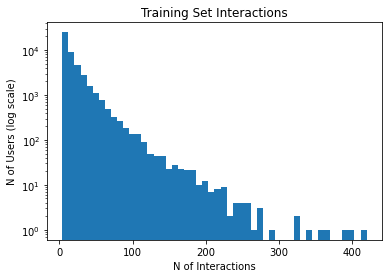

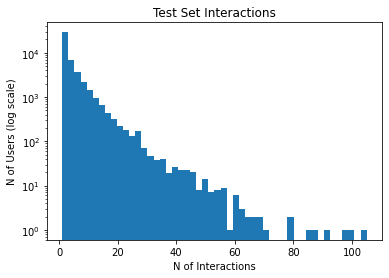

Training set sparsity: 0.9987575045767755
Test set sparsity: 0.9997195153215211
n interactions in training set: 895660
n interactions in test set: 202189


In [62]:
# plot distr for training & test sets
def plot_interaction_distribution(interactions, title):
    user_interactions = {}
    for user, _ in interactions:
        user_interactions[user] = user_interactions.get(user, 0) + 1

    plt.hist(user_interactions.values(), bins=50, log=True) # Log allows also to see the small values
    plt.title(title)
    plt.xlabel('N of Interactions')
    plt.ylabel('N of Users (log scale)')
    plt.show()
plot_interaction_distribution(train_interactions, 'Training Set Interactions')
plot_interaction_distribution(test_interactions, 'Test Set Interactions')

#have a look at sparsity (should be very high)
def calculate_sparsity(matrix):
    total_possible_interactions = matrix.shape[0] * matrix.shape[1]
    actual_interactions = len(matrix.nonzero()[0])
    sparsity = 1 - (actual_interactions / total_possible_interactions)
    return sparsity

train_sparsity = calculate_sparsity(train_matrix)
test_sparsity = calculate_sparsity(test_matrix)
print("Training set sparsity:", train_sparsity)
print("Test set sparsity:", test_sparsity)
print("n interactions in training set:", len(train_interactions))
print("n interactions in test set:", len(test_interactions))


typical long tail distrib. good that it is  consistent: <br>
TRAIN: few users have >400 , most of them around 40-50<br>
TEST: few >100 in test, most around 20 interaction.<br>


<h1 style="color:rgb(0,120,170)">Baseline POP-Recommender</h1>

------------------------------------------------------

<a id="Baseline"></a>
Attenzione: matrix deve essere csr!!!

In [71]:
def pop_baseline(interaction_matrix: csr_matrix, user_id: int, k=10):
   
    item_popularity = np.array(interaction_matrix.sum(axis=0)).flatten() #calc pop
    interacted_indices = interaction_matrix[user_id].nonzero()[1] #already seen items
    non_interacted_items = np.setdiff1d(np.arange(interaction_matrix.shape[1]), interacted_indices, assume_unique=True) #filtered out
    non_interacted_popularity = item_popularity[non_interacted_items] #sort the remaining ones
    popular_non_interacted_items = non_interacted_items[np.argsort(non_interacted_popularity)[::-1]][:n]
    
    return popular_non_interacted_items


In [74]:
u_0 = pop_baseline(train_matrix, user_id=0, k=10) 
u_1 = pop_baseline(train_matrix, user_id=1, k=10)
u_0, u_1


(array([ 4586,  5647, 15385, 13931,  6557,  4742, 11008, 14604, 11625,
        12111]),
 array([ 4586, 12728,  5647,  8374, 15385,   879, 13931,  2799,  6557,
         4742]))

<h1 style="color:rgb(0,120,170)">Evaluation</h1>

------------------------------------------------------
https://towardsdatascience.com/how-to-assess-recommender-systems-10afd6c1fae0
<a id="Evaluation"></a>

In [ ]:
def evaluate(interaction_matrix, test_interactions, pop_rec_function, k=10):
    precision_at_k_list = []
    recall_at_k_list = []

    test_users = set(user for user, _ in test_interactions) #unique users
    
    for user_id in test_users:
        
        test_items = [item for user, item in test_interactions if user == user_id] #get interracted items
        recommended_items = pop_rec_function(interaction_matrix, user_id, n=k)     #get recommendations
        hits_at_k = len(set(recommended_items) & set(test_items))                  #calc hits

        #calculate precision&recall @ k
        precision_at_k = hits_at_k / k
        recall_at_k = hits_at_k / len(test_items) if test_items else 0
        precision_at_k_list.append(precision_at_k)
        recall_at_k_list.append(recall_at_k)

    #average across all users
    avg_precision_at_k = np.mean(precision_at_k_list)
    avg_recall_at_k = np.mean(recall_at_k_list)

    return avg_precision_at_k, avg_recall_at_k

In [76]:
k=10
print(f"Average Precision@{k}: {avg_precision_at_k}") #0.014720779499506374
print(f"Average Recall@{k}: {avg_recall_at_k}") #0.043537391233408614

Average Precision@10: 0.014720779499506374
Average Recall@10: 0.043537391233408614
